$\textbf{PROGRAMMING ASSIGNMENT}$
---
1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
---

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.special import logsumexp
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

In [31]:
class BernoulliMixtureStochasticEM:
    def __init__(self, num_components, max_iterations, batch_size, random_state=None):
        self.num_components = num_components
        self.max_iterations = max_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        # Initialize old parameters
        self.prev_mu = None
        self.prev_pi = None
        self.prev_gamma = None
    
    def fit(self, binary_data):
        self.data = binary_data
        self.init_params()
        log_bernoullis = self.compute_log_bernoullis(self.data)
        self.old_log_likelihood = self.calculate_log_likelihood(log_bernoullis)
        for step in range(self.max_iterations):
            if step > 0:
                self.old_log_likelihood = self.log_likelihood
            # Stochastic E-step and M-step
            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.data), size=self.batch_size, replace=False)
                batch_data = self.data[batch_indices]
                batch_log_bernoullis = self.compute_log_bernoullis(batch_data)
                self.gamma = self.calculate_responsibilities(batch_log_bernoullis)
                self.compute_effective_counts()
                self.compute_component_means(batch_data)
                self.compute_mixture_weights()
            # Compute new log_likelihood:
            log_bernoullis = self.compute_log_bernoullis(self.data)
            self.log_likelihood = self.calculate_log_likelihood(log_bernoullis)
            if np.isnan(self.log_likelihood):
                self.reset_params()
                print(self.log_likelihood)
                break

    def reset_params(self):
        if self.prev_mu is not None:
            self.mu = self.prev_mu.copy()
        if self.prev_pi is not None:
            self.pi = self.prev_pi.copy()
        if self.prev_gamma is not None:
            self.gamma = self.prev_gamma.copy()
        self.compute_effective_counts()
        log_bernoullis = self.compute_log_bernoullis(self.data)
        self.log_likelihood = self.calculate_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.prev_mu = self.mu.copy()
        self.prev_pi = self.pi.copy()
        self.prev_gamma = self.gamma.copy()
    
    def init_params(self):
        self.num_samples = self.data.shape[0]
        self.num_features = self.data.shape[1]
        self.pi = 1/self.num_components * np.ones(self.num_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.num_components, self.num_features))
        self.normalize_component_means()
    
    def normalize_component_means(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.num_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def calculate_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.num_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.num_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def compute_log_bernoullis(self, data):
        log_bernoullis = self.compute_log_probability(data, self.mu)
        log_bernoullis += self.compute_log_probability(1-data, 1-self.mu)
        return log_bernoullis
    
    def compute_log_probability(self, data, mu):
        epsilon = 1e-100 
        mu_place = np.where(np.max(mu, axis=0) <= epsilon, epsilon, mu)
        return np.tensordot(data, np.log(mu_place), (1,1))


        
    def compute_effective_counts(self):
        self.effective_counts = np.sum(self.gamma, axis=0)
    
    def compute_component_means(self, batch_data):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, batch_data) / self.effective_counts[:,None]

        
    def compute_mixture_weights(self):
        self.pi = self.effective_counts / self.num_samples
    
    def predict(self, data):
        log_bernoullis = self.compute_log_bernoullis(data)
        gamma = self.calculate_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def calculate_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def calculate_log_likelihood(self, log_bernoullis):
        return np.mean(self.calculate_sample_log_likelihood(log_bernoullis))
        
    def score(self, data):
        log_bernoullis = self.compute_log_bernoullis(data)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
---

In [3]:
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
X = soybean_large.data.features 
y = soybean_large.data.targets 

# metadata 
print(soybean_large.metadata) 
  
# variable information 
print(soybean_large.variables) 

{'uci_id': 90, 'name': 'Soybean (Large)', 'repository_url': 'https://archive.ics.uci.edu/dataset/90/soybean+large', 'data_url': 'https://archive.ics.uci.edu/static/public/90/data.csv', 'abstract': "Michalski's famous soybean disease database", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 307, 'num_features': 35, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1980, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5JG6Z', 'creators': ['R.S. Michalski', 'R.L. Chilausky'], 'intro_paper': None, 'additional_info': {'summary': 'There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples. There are 35 categorical attributes, some nominal and some ordered.  The

In [24]:
data = pd.concat([X, y], axis=1)
print(data)

     date  plant-stand  precip  temp  hail  crop-hist  area-damaged  severity  \
0     6.0          0.0     2.0   1.0   0.0        1.0           1.0       1.0   
1     4.0          0.0     2.0   1.0   0.0        2.0           0.0       2.0   
2     3.0          0.0     2.0   1.0   0.0        1.0           0.0       2.0   
3     3.0          0.0     2.0   1.0   0.0        1.0           0.0       2.0   
4     6.0          0.0     2.0   1.0   0.0        2.0           0.0       1.0   
..    ...          ...     ...   ...   ...        ...           ...       ...   
302   NaN          NaN     NaN   NaN   NaN        NaN           NaN       NaN   
303   1.0          1.0     NaN   0.0   NaN        1.0           0.0       NaN   
304   0.0          1.0     NaN   0.0   NaN        0.0           3.0       NaN   
305   1.0          1.0     NaN   0.0   NaN        0.0           0.0       NaN   
306   1.0          1.0     NaN   0.0   NaN        1.0           3.0       NaN   

     seed-tmt  germination 

5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
---

In [37]:
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed).toarray()  

n_components = 3
max_iter = 100
batch_size = 50

stochastic_bmm = BernoulliMixtureStochasticEM(num_components=n_components, max_iterations=max_iter, batch_size=batch_size)
warnings.filterwarnings("ignore", category=RuntimeWarning)
stochastic_bmm.fit(X_encoded)

cluster_assignments = stochastic_bmm.predict(X_encoded)

nan


C:\Users\ivanne bayer\AppData\Local\Temp\ipykernel_27472\904554587.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)  # Adjusting alpha value for transparency


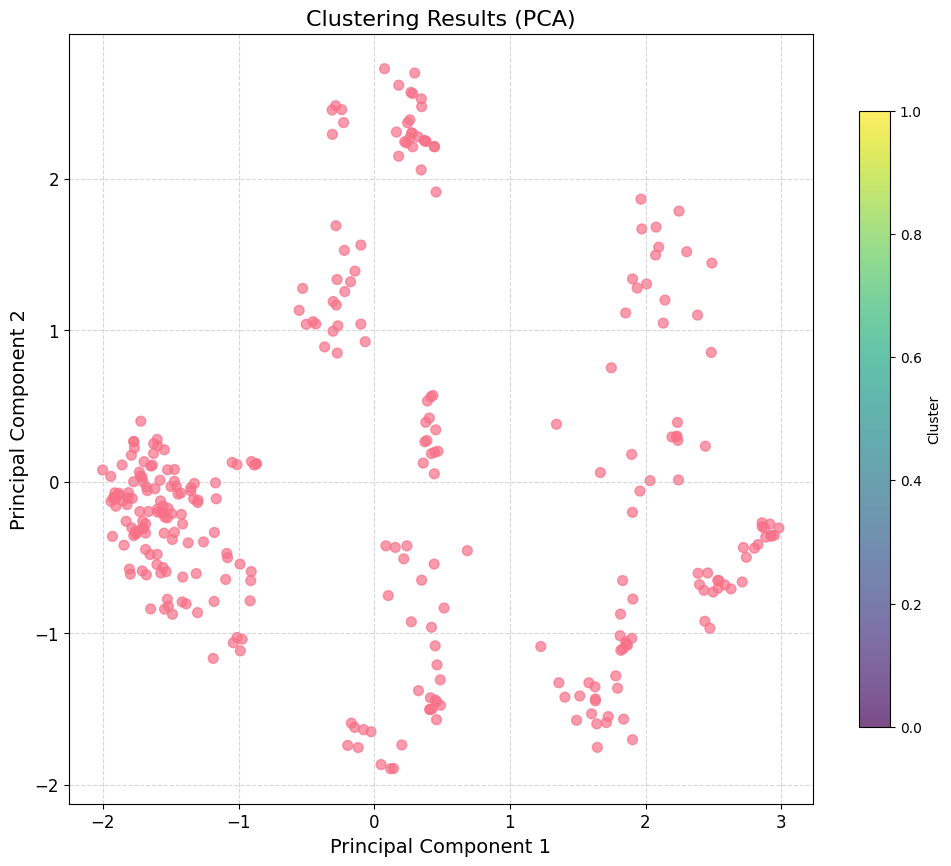

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

new_palette = sns.color_palette("husl", n_colors=len(np.unique(cluster_assignments)))
colors = [new_palette[i] for i in cluster_assignments]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)  # Adjusting alpha value for transparency
plt.title('Clustering Results (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14) 
plt.ylabel('Principal Component 2', fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(scatter, label='Cluster', shrink=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
---

In [60]:
kmodes = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
kmodes.fit(X_imputed)

kmodes_cluster_assignments = kmodes.labels_

y_true_flat = y.values.ravel()

kmodes_ari = adjusted_rand_score(y_true_flat, kmodes_cluster_assignments)
kmodes_nmi = normalized_mutual_info_score(y_true_flat, kmodes_cluster_assignments)
kmodes_fmi = fowlkes_mallows_score(y_true_flat, kmodes_cluster_assignments)

sbm_ari = adjusted_rand_score(y_true_flat, cluster_assignments)
sbm_nmi = normalized_mutual_info_score(y_true_flat, cluster_assignments)
sbm_fmi = fowlkes_mallows_score(y_true_flat, cluster_assignments)

**Performance Comparison (KModes)**

In [65]:
print("KModes - Adjusted Rand Index (ARI):", kmodes_ari)
print("KModes - Normalized Mutual Information Score (NMI):", kmodes_nmi)
print("KModes - Folkes-Mallows Index (FMI):", kmodes_fmi)

KModes - Adjusted Rand Index (ARI): 0.16608388765264684
KModes - Normalized Mutual Information Score (NMI): 0.4020358135575015
KModes - Folkes-Mallows Index (FMI): 0.37946365260388987


**Performance Comparison (Stochastic Bernoulli Mixture)**

In [64]:
print("Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI):", sbm_ari)
print("Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI):", sbm_nmi)
print("Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI):", sbm_fmi)

Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI): 0.0
Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI): 0.0
Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI): 0.2896598585640133


7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

---

## Performance Comparison Report

In this report, a comparison is made between the performance of the KModes clustering algorithm and the Stochastic Bernoulli Mixture (SBM) model across three metrics: Adjusted Rand Index (ARI), Normalized Mutual Information Score (NMI), and Folkes-Mallows Index (FMI).

|                           | Adjusted Rand Index (ARI) | Normalized Mutual Information Score (NMI) | Folkes-Mallows Index (FMI) |
|---------------------------|---------------------------|--------------------------------------------|----------------------------|
| **KModes**                | 0.166                     | 0.402                                      | 0.379                      |
| **Stochastic Bernoulli Mixture** | 0.0                  | 0.0                                        | 0.290                      |


### Comparison and Contrast:

1. **Adjusted Rand Index (ARI):**
   - KModes achieves a moderate ARI of 0.166, indicating a fair agreement between the clusters produced by KModes and the true labels.
   - In contrast, the SBM model achieves an ARI of 0.0, suggesting that the cluster assignments from SBM do not agree with the true labels.

2. **Normalized Mutual Information Score (NMI):**
   - KModes demonstrates a relatively higher NMI of 0.402, indicating a moderate level of mutual information between the predicted clusters and the true labels.
   - On the other hand, the SBM model yields an NMI of 0.0, indicating no mutual information between the predicted clusters and the true labels.

3. **Folkes-Mallows Index (FMI):**
   - KModes achieves an FMI of 0.379, indicating a reasonable similarity between the clusters produced by KModes and the true labels.
   - The SBM model exhibits an FMI of 0.290, suggesting some level of similarity between the predicted clusters and the true labels, albeit lower than that of KModes.

### Insights:

- **Interpretation of ARI, NMI, and FMI:**
  - ARI measures the similarity between two clusterings, disregarding permutations of cluster labels. A score close to 1 indicates a perfect match.
  - NMI measures the mutual information between two clusterings, normalized to fall between 0 and 1. A higher NMI indicates greater agreement between the clusterings.
  - FMI computes the geometric mean of precision and recall of clustering, with values closer to 1 indicating better clustering performance.

- **Comparing Performance:**
  - KModes generally outperforms the SBM model across all metrics, suggesting that KModes produces more accurate cluster assignments compared to SBM.
  - The low performance of the SBM model, especially in terms of ARI and NMI, indicates that the clustering produced by SBM does not align well with the true labels.

- **Potential Explanations:**
  - The discrepancy in performance could be attributed to the underlying assumptions and methodologies of the two algorithms.
  - KModes is specifically designed for categorical data and may capture the inherent structures more effectively in this context.
  - The SBM model, while flexible, may not be well-suited for the given dataset or may require further tuning of parameters to achieve better results.

- **Implications and Recommendations:**
  - Based on these results, researchers and practitioners may opt for KModes when dealing with categorical data, given its superior performance in this scenario.
  - Further investigation into the SBM model's parameter settings and suitability for the dataset may be warranted to improve its performance.

### Conclusion:

In conclusion, the comparison highlights the importance of selecting appropriate clustering algorithms based on the nature of the data and the desired outcomes. While KModes demonstrates relatively better performance in this context, further experimentation and refinement may be necessary to fully leverage the capabilities of both algorithms.